# Updates

After updating packages, restart the session and then start your notebook from imports.

# Imports

In [30]:
# import torch
# from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import pandas as pd
import re
import string
import spacy
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Reading Json Files

In [31]:
def jsonl_tolist(jsonl_file_path):
    records = []
    with open(jsonl_file_path, 'r') as f:
        for line in f:
            record = json.loads(line)
            records.append(record)
    return records


In [32]:
jsonl_files_path = {
    "train": "imdb/train_imdb.jsonl",
    "test": "imdb/test_imdb.jsonl",
    "unlabeled": "imdb/aug_imdb_unlabeled.jsonl"
}

In [33]:
df_train = pd.DataFrame(jsonl_tolist(jsonl_files_path["train"]))
df_test = pd.DataFrame(jsonl_tolist(jsonl_files_path["test"]))
df_unlabeled = pd.DataFrame(jsonl_tolist(jsonl_files_path["unlabeled"]))

In [34]:
df_train.to_csv("CSVs/train.csv")
df_test.to_csv("CSVs/test.csv")
df_unlabeled.to_csv("CSVs/unlabeled.csv")

In [35]:
def get_feature_columns_name(df):
    features_columns = []
    for i in range(len(df["embedding"][0])):
        name = "feature" + f"{i + 1}"
        features_columns.append(name)
    return features_columns

In [36]:
df_train[get_feature_columns_name(df_train)] = df_train["embedding"].apply(pd.Series)
df_test[get_feature_columns_name(df_test)] = df_test["embedding"].apply(pd.Series)
df_unlabeled[get_feature_columns_name(df_unlabeled)] = df_unlabeled["embedding"].apply(pd.Series)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13456\1150993862.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[get_feature_columns_name(df_train)] = df_train["embedding"].apply(pd.Series)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13456\1150993862.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[get_feature_columns_name(df_train)] = df_train["embedding"].apply(pd.Series)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13456\1150993862.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usual

In [37]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)


In [38]:
def to_lowercase(text):
    return text.lower()

In [39]:
def remove_digits(text):
    return re.sub("\w*\d\w*", "", text)

In [40]:
def remove_punctuation(text):
    return re.sub("[%s]" % re.escape(string.punctuation), "", text)

In [41]:
def remove_short_words(text):
        return " ".join(word for word in text.split() if len(word) >= 3 or word.lower() == "no")

In [42]:
def remove_extra_spaces(text):
    return re.sub(" +", " ", text)

In [43]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

negation_words = {"not", "no", "never", "none", "nobody", "nothing", "neither", "nowhere", "cannot"}

def lemmatize_and_remove_stop_words(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop or token.text.lower() in negation_words])

In [44]:
def calculate_polarity(text):
    return TextBlob(text).sentiment.polarity

In [45]:
def preprocess_dataframe(df):
    df = df.copy()
    df["text"] = df["text"].apply(expand_contractions)
    df["text"] = df["text"].apply(to_lowercase)
    df["text"] = df["text"].apply(remove_digits)
    df["text"] = df["text"].apply(remove_punctuation)
    df["text"] = df["text"].apply(remove_short_words)
    df["text"] = df["text"].apply(remove_extra_spaces)
    df["text"] = df["text"].apply(lemmatize_and_remove_stop_words)
    df["polarity"] = df["text"].apply(calculate_polarity)
    return df

In [46]:
df_train = preprocess_dataframe(df_train)
df_test = preprocess_dataframe(df_test)
df_unlabeled = preprocess_dataframe(df_unlabeled)

## Understanding the common words used in the texts

In [50]:
def plot_common_words(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

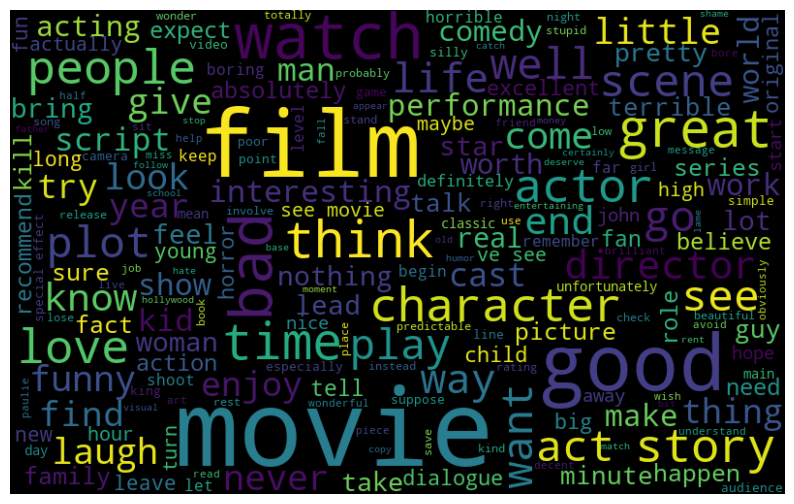

In [51]:
combi = pd.concat([df_train, df_test], ignore_index=True)
all_words = " ".join([text for text in combi["text"]])
plot_common_words(all_words)

### Words in non positive texts

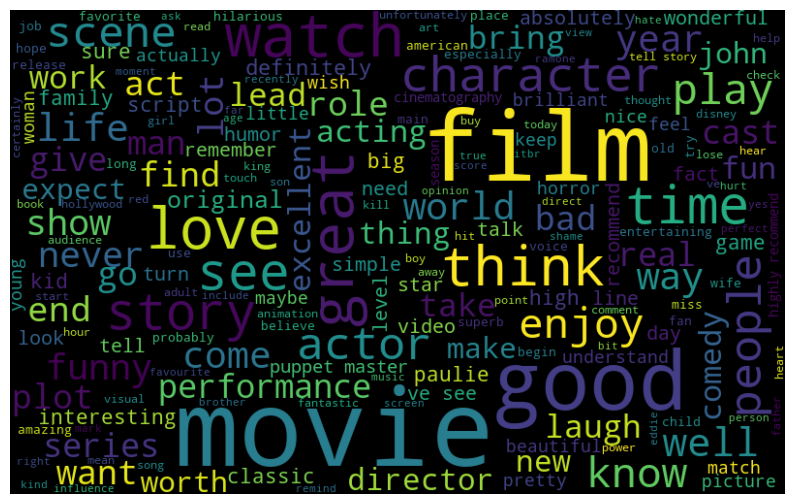

In [52]:
positive_words = " ".join([text for text in combi["text"][combi["label"] == 1]])
plot_common_words(positive_words)

### Words in negative texts

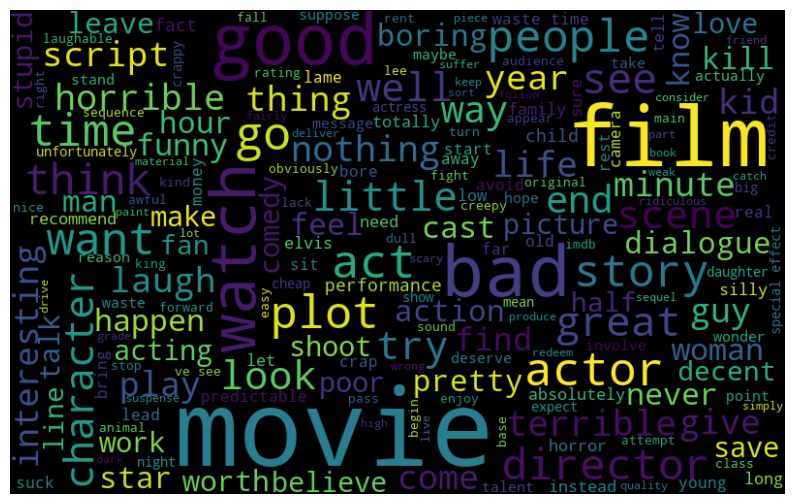

In [53]:
negation_words = " ".join([text for text in combi["text"][combi["label"] == 0]])
plot_common_words(negation_words)

In [54]:
df_train

,text,label,embedding,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature760,feature761,feature762,feature763,feature764,feature765,feature766,feature767,feature768,polarity
0,fairly good romantic comedy not think ve see m...,1,"[-0.0167805497, -0.0395836979, 0.1233159453, -...",-0.016781,-0.039584,0.123316,-0.112681,0.147103,0.022566,0.053462,...,-0.195328,0.035722,-0.379844,-0.180571,-0.036396,0.114420,-0.036291,0.421711,0.060781,0.316942
1,dress kill good thriller dealing sex violence ...,1,"[-0.1252697259, 0.1014768854, 0.1718291789, -0...",-0.125270,0.101477,0.171829,-0.150420,0.494087,-0.016729,-0.013425,...,-0.187593,0.028957,-0.121169,-0.393291,0.200559,0.443822,-0.081122,0.346749,0.065129,0.326667
2,glad user date like movie come forward not und...,1,"[0.1312361956, 0.0294876788, 0.2328549027, -0....",0.131236,0.029488,0.232855,-0.002422,0.081981,-0.063562,0.132140,...,-0.165477,0.012854,-0.191873,-0.312853,0.013078,0.150811,-0.169557,0.233549,0.052898,0.043095
3,need excuse house paint dry leave movie hour r...,0,"[0.1387384981, 0.0460377187, 0.3447172046, -0....",0.138738,0.046038,0.344717,-0.042892,0.225556,-0.144981,0.023403,...,-0.077552,-0.013346,-0.228877,-0.144858,-0.075651,-0.076263,0.022555,0.092200,-0.068175,-0.253319
4,john candy performance crime possibly good fav...,1,"[0.1606466323, -0.1768193543, 0.3563380837, -0...",0.160647,-0.176819,0.356338,-0.119723,0.257010,-0.037752,0.053498,...,-0.103852,0.013501,-0.221421,-0.197348,0.124097,0.090596,0.123112,0.122473,0.097609,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,film think great journey forr gump rare treat ...,1,"[-0.0127362479, -0.1083025485, 0.151258871, 0....",-0.012736,-0.108303,0.151259,0.018022,0.281201,-0.304326,-0.005685,...,-0.103134,0.062240,-0.161306,-0.152781,0.220059,0.102940,-0.042109,0.171636,0.166082,0.281667
146,want long time james merendino great director ...,1,"[-0.0872147828, -0.1653934121, 0.238217473, -0...",-0.087215,-0.165393,0.238217,-0.081272,0.315752,-0.097431,-0.027156,...,-0.146171,0.079091,-0.376557,-0.266569,0.103020,0.086039,-0.091507,0.265124,-0.024546,0.430000
147,egyptian movie lot filme high level drama roma...,0,"[0.0326799825, 0.0344635732, 0.3442422152, -0....",0.032680,0.034464,0.344242,-0.275831,0.163914,-0.428903,0.221885,...,-0.002559,0.116916,-0.336276,-0.309363,-0.234953,-0.053021,-0.354898,0.348796,-0.058987,0.290000
148,antibush joke easy like well sure extra extra ...,0,"[-0.039546337, -0.04593236, 0.119179666, 0.087...",-0.039546,-0.045932,0.119180,0.087794,0.086585,-0.269455,-0.032886,...,-0.009202,0.032049,-0.106289,0.044190,0.030491,0.212227,-0.070574,0.261716,0.209701,0.162771


# Load model

In [ ]:
MODEL_ARGS = {
    'Name': 'microsoft/Phi-3-mini-128k-instruct',
    'DType': bfloat16
}

In [ ]:
def load_model(model_args):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = AutoModelForCausalLM.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
        torch_dtype=torch.model_args['DType'],
        low_cpu_mem_usage=True,
        device_map={"": device},
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
    )

    return model, tokenizer

Good luck :)